In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import glob
import numpy as np
import open3d as o3d
import time

import matplotlib.pyplot as plt
from progressbar import *

from MatlabTests.python.read_write_model import *
from MatlabTests.python.read_dense import *

from Bastian_utils.FloorSegment import *

In [2]:
def get_image_depth_and_segment(image_file):
    rgb = cv2.imread(image_file)
    
    image_name = image_file.split("/")[-1]
    depth_path = worksapce_path + '/depth/' + image_name + '.geometric.bin'
    mvs_depth = read_array(depth_path)
    
    seg_ade20k = np.load(worksapce_path+"/segmentation/"+image_name+".npy")[0,:,:]
    seg_ade20k_show = cv2.imread(worksapce_path+"/segmentation/"+image_name+".png")
    
    seg_ade20k = cv2.resize(seg_ade20k, (mvs_depth.shape[1], mvs_depth.shape[0]) ,interpolation=cv2.INTER_NEAREST)
    return rgb, mvs_depth, seg_ade20k, seg_ade20k_show

In [16]:
def rank_images(images):
    ids = []
    for image in images:
        id_str = image.split('\\')[-1][:-4]
        ids.append(int(id_str))
        
    rank = np.argsort(np.asarray(ids))
    return [images[i] for i in rank]

In [17]:
worksapce_path = "./WinterThirdFloor/winter_third_floor_results/"
images_folder = worksapce_path + "/images/"
sub_folders = ['cut_'+str(i+1) for i in range(3)]
images_all = []
for sub_folder in sub_folders:
    images = glob.glob(images_folder+ sub_folder + "/*.png")
    images = rank_images(images)
    images_all = images_all + images
print("==> Loaded", len(images_all), "images")

==> Loaded 4419 images


# Process Test

In [5]:
camera_parameters = [640,480,500,500,320,240]
camera_mtx = np.array([[camera_parameters[2],0,camera_parameters[4]],
                                [0,camera_parameters[3],camera_parameters[5]],
                                [0,0,1]])

Time consumption : 0.09477710723876953


(-0.5, 624.5, 467.5, -0.5)

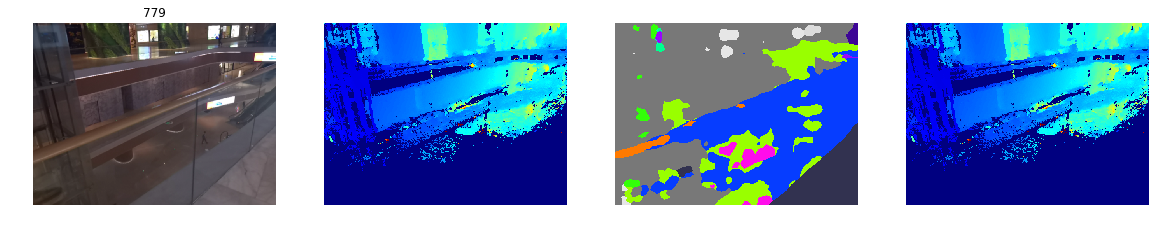

In [76]:
#idx = np.random.randint(0,len(images))
idx = 779
rgb, mvs_depth, seg_ade20k, seg_ade20k_show = get_image_depth_and_segment(images_all[idx])

mask= seg_ade20k!=4
kernel = np.ones((5,5), dtype=np.uint8)
mask = cv2.dilate(np.array(mask).astype(np.float32), kernel,iterations=10)
mask = cv2.erode(np.array(mask).astype(np.float32), kernel,iterations=5)
mask = mask == 1

floor_depth = mvs_depth.copy()
floor_depth[mask] = 0

iterations = 2000
tic = time.time()
result = floor_repairment(mvs_depth, mask, camera_mtx, iterations)
result = floor_repairment(result, mask, camera_mtx, iterations/2, True)
print("Time consumption :", time.time() - tic)

plt.figure(figsize=(20,5))
#mvs_depth = cv2.applyColorMap(cv2.convertScaleAbs(mvs_depth,alpha=30),cv2.COLORMAP_JET)
plt.subplot(141); plt.imshow(cv2.cvtColor(rgb, 4)); plt.axis("off"); plt.title(str(idx))
plt.subplot(142); plt.imshow(cv2.cvtColor(cv2.applyColorMap(cv2.convertScaleAbs(mvs_depth,alpha=30),cv2.COLORMAP_JET),4)); plt.axis("off")
plt.subplot(143); plt.imshow(seg_ade20k_show); plt.axis("off")
plt.subplot(144);plt.imshow(cv2.cvtColor(cv2.applyColorMap(cv2.convertScaleAbs(result,alpha=30),cv2.COLORMAP_JET),4)); plt.axis("off")

In [61]:
# cloud, colors = get_cloud(rgb, result, np.ones(result.shape), camera_mtx, True)

# point_cloud_o3d_i = o3d.geometry.PointCloud()
# point_cloud_o3d_i.points = o3d.utility.Vector3dVector(cloud)
# point_cloud_o3d_i.colors = o3d.utility.Vector3dVector(colors)

# axis_o3d = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
# o3d.visualization.draw_geometries([axis_o3d, point_cloud_o3d_i])

# Process for all images

In [63]:
#save_folder_del = "./WinterThirdFloor/plane_completion/floor_del/"
save_folder_fill = "./WinterThirdFloor/plane_completion/floor_fill/"

In [14]:
# bar = ProgressBar()
# for idx in bar(range(len(images))):
#     rgb, mvs_depth, seg_ade20k, seg_ade20k_show = get_image_depth_and_segment(images[idx])

#     mask= seg_ade20k!=4
#     kernel = np.ones((5,5), dtype=np.uint8)
#     mask = cv2.dilate(np.array(mask).astype(np.float32), kernel,iterations=5)
#     mask = mask == 1

#     floor_depth = mvs_depth.copy()
#     floor_depth[mask] = 0

#     iterations = 100
#     tic = time.time()
#     result = floor_repairment(mvs_depth, mask, camera_mtx, iterations)
#     result = floor_repairment(result, mask, camera_mtx, iterations/2, False)
    
#     image_name = images[idx].split("\\")[-1]
#     depth_show = cv2.applyColorMap(cv2.convertScaleAbs(result,alpha=30),cv2.COLORMAP_JET)
#     cv2.imwrite(save_folder_del + image_name + ".jpg", depth_show);

In [81]:
bar = ProgressBar()
for idx in bar(range(778, len(images_all))):
    rgb, mvs_depth, seg_ade20k, seg_ade20k_show = get_image_depth_and_segment(images_all[idx])

    mask= seg_ade20k!=4
    kernel = np.ones((5,5), dtype=np.uint8)
    mask = cv2.dilate(np.array(mask).astype(np.float32), kernel,iterations=5)
    mask = mask == 1

    floor_depth = mvs_depth.copy()
    floor_depth[mask] = 0

    iterations = 100
    tic = time.time()
    result = floor_repairment(mvs_depth, mask, camera_mtx, iterations)
    result = floor_repairment(result, mask, camera_mtx, iterations/2, True)
    
    image_name = images_all[idx].split("/")[-1]
    depth_show = cv2.applyColorMap(cv2.convertScaleAbs(result,alpha=30),cv2.COLORMAP_JET)
    np.save(save_folder_fill + image_name + ".npy", result);
    cv2.imwrite(save_folder_fill + image_name + ".jpg", depth_show);

100% |########################################################################|


# Open3d plane segmentation test

Time consumption : 1.7054412364959717


(-0.5, 624.5, 467.5, -0.5)

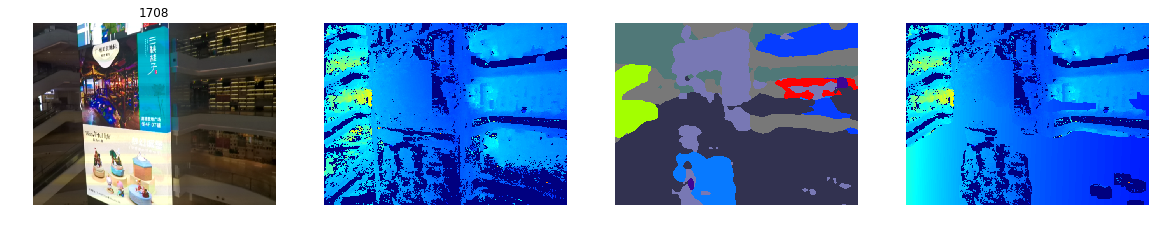

In [59]:
#idx = 263
#idx = np.random.randint(0,len(images))
idx = 1708
image_file = images[idx]
rgb, mvs_depth, seg_ade20k, seg_ade20k_show = get_image_depth_and_segment(image_file)

mask= seg_ade20k!=4
kernel = np.ones((5,5), dtype=np.uint8)
mask = cv2.dilate(np.array(mask).astype(np.float32), kernel,iterations=5)
mask = mask == 1

floor_depth = mvs_depth.copy()
floor_depth[mask] = 0

tic = time.time()
result = floor_repairment_o3d(mvs_depth, mask, camera_mtx, False)
print("Time consumption :", time.time() - tic)

plt.figure(figsize=(20,5))
#mvs_depth = cv2.applyColorMap(cv2.convertScaleAbs(mvs_depth,alpha=30),cv2.COLORMAP_JET)
plt.subplot(141); plt.imshow(cv2.cvtColor(rgb, 4)); plt.axis("off"); plt.title(str(idx))
plt.subplot(142); plt.imshow(cv2.cvtColor(cv2.applyColorMap(cv2.convertScaleAbs(mvs_depth,alpha=30),cv2.COLORMAP_JET),4)); plt.axis("off")
plt.subplot(143); plt.imshow(seg_ade20k_show); plt.axis("off")
plt.subplot(144);plt.imshow(cv2.cvtColor(cv2.applyColorMap(cv2.convertScaleAbs(result,alpha=30),cv2.COLORMAP_JET),4)); plt.axis("off")

In [10]:
# cloud, colors = get_cloud(rgb, result, np.ones(result.shape), camera_mtx)

# point_cloud_o3d_i = o3d.geometry.PointCloud()
# point_cloud_o3d_i.points = o3d.utility.Vector3dVector(cloud)
# point_cloud_o3d_i.colors = o3d.utility.Vector3dVector(colors)

# o3d.visualization.draw_geometries([point_cloud_o3d_i], window_name='Open3D', width=1920, height=1080, left=50, top=50,
#                                   point_show_normal=False, mesh_show_wireframe=False, mesh_show_back_face=False)

In [80]:
# cloud, colors = get_cloud(rgb, mvs_depth, mask, camera_mtx)

# point_cloud_o3d_i = o3d.geometry.PointCloud()
# point_cloud_o3d_i.points = o3d.utility.Vector3dVector(cloud)
# point_cloud_o3d_i.colors = o3d.utility.Vector3dVector(colors)

# inlier_cloud, outlier_cloud = floor_repairment_o3d(mvs_depth, mask, camera_mtx, True)

# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, point_cloud_o3d_i], window_name='Open3D', width=1920, height=1080, left=50, top=50,
#                                   point_show_normal=False, mesh_show_wireframe=False, mesh_show_back_face=False)

### Process all

In [79]:
save_folder_o3d = "./WinterThirdFloor/plane_completion/floor_o3d/"

bar = ProgressBar()
for idx in bar(range(0, len(images_all))):
    rgb, mvs_depth, seg_ade20k, seg_ade20k_show = get_image_depth_and_segment(images_all[idx])

    mask= seg_ade20k!=4
    kernel = np.ones((5,5), dtype=np.uint8)
    mask = cv2.dilate(np.array(mask).astype(np.float32), kernel,iterations=5)
    mask = mask == 1

    floor_depth = mvs_depth.copy()
    floor_depth[mask] = 0

    iterations = 100
    tic = time.time()
    result = floor_repairment_o3d(mvs_depth, mask, camera_mtx, False)
    
    image_name = images_all[idx].split("/")[-1]
    depth_show = cv2.applyColorMap(cv2.convertScaleAbs(result,alpha=30),cv2.COLORMAP_JET)
    np.save(save_folder_o3d + image_name + ".npy", result);
    cv2.imwrite(save_folder_o3d + image_name + ".jpg", depth_show);

100% |########################################################################|


### result 

* Get more robust plane segmentation
* While the reconstruction based on it doesn't go well. it ends up with some strange line segment textures.

![o3d result](garden/floor_process/o3d_version.PNG)

### Conclusion 

We should update/refine our implementation of the ground detection, while will have a much better result.